In [1]:
import findspark
findspark.init("/opt/spark")
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
from pyspark import sql

conf = SparkConf().setAppName("SO_project").setMaster("spark://damiani-master-slave-0:7077")
sc = SparkContext(conf = conf)
sqlContext = sql.SQLContext(sc)

In [7]:
import sh
hdfsdir = '/user/ubuntu/hdfs/dataset'
files = [ line.rsplit(None,1)[-1] for line in sh.hdfs('dfs','-ls',hdfsdir).split('\n') if len(line.rsplit(None,1))][2:]   

In [8]:
 rdd = sc.textFile(files[0])

In [9]:
rdd.take(5)

[u'targa;varco;corsia;timestamp;nazione',
 u'1645281;10;2.0;2016-07-03 12:51:56;?',
 u'8382057;2;1.0;2016-07-03 19:06:16;?',
 u'145319;20;1.0;2016-07-03 08:46:59;?',
 u'145319;25;1.0;2016-07-03 08:34:56;?']

In [10]:
files = files[:4]
for x in files : print x 

/user/ubuntu/hdfs/dataset/03.07.2016.csv
/user/ubuntu/hdfs/dataset/04.07.2016.csv
/user/ubuntu/hdfs/dataset/05.07.2016.csv
/user/ubuntu/hdfs/dataset/06.07.2016.csv


In [4]:
def apply_preprocessing(rdd) :
    '''
    This function applies some transformations in order to have a dataset with this shape: ((plate,path),times)
     - **parameters**, **types**, **return** and **return types**::
          :param rdd: RDD to transform
          :type rdd: pyspark.rdd.RDD
          :return: return the transformed RDD 
          :rtype: pyspark.rdd.RDD
    '''
    header = rdd.first()
    rdd = rdd.filter(lambda lines : lines!=header)
    rdd = rdd.map(lambda lines : lines.split(";")).map(lambda (l1,l2,l3,l4,l5) : (l1,str(l2))).reduceByKey(lambda g1,g2: str(g1)+"-"+str(g2))
    rdd = rdd.map(lambda (plate,path) : ((plate,path),1))
    return rdd 

In [5]:
def update(rdd,rdd_new) :
    '''
    Given two RDDs, this function provides a new RDD, which is the union of the RDDs.
    Additionally, the field "times" of the new RDD has been updated. 
     - **parameters**, **types**, **return** and **return types**::
          :param rdd,rdd_new: one of the RDDs to compare
          :type rdd,rdd_new: pyspark.rdd.RDD
          :return: return the new RDD 
          :rtype: pyspark.rdd.RDD
    '''
    result = rdd.union(rdd_new)
    result = result.reduceByKey(lambda a,b : a+b)
    return result

In [6]:
def main() :
    rdd_info = sc.textFile("hdfs:/"+files[0])
    rdd_info = apply_preprocessing(rdd_info)
    
    for file_path in files[1:] : 
        rdd_new = sc.textFile(file_path)
        rdd_new = apply_preprocessing(rdd_new)
        rdd_info = update(rdd_info,rdd_new)
    return rdd_info    

In [7]:
%time rdd = main()

CPU times: user 114 ms, sys: 6.22 ms, total: 120 ms
Wall time: 7.53 s


In [8]:
%time rdd.take(5)

CPU times: user 20.7 ms, sys: 1.01 ms, total: 21.7 ms
Wall time: 1min 4s


[((u'1781733', '22-1-12-14-8-3'), 1),
 ((u'748072', '13-3-8-5-23-18-10-9'), 1),
 ((u'703145', '9-10-18-23-5-8-3-13'), 1),
 ((u'7656964', '16-2'), 1),
 ((u'8530468', '18'), 1)]

In [9]:
%time num_path = rdd.map(lambda ((plate,path),times) : (path,1)).keys().distinct().count()
print num_path

CPU times: user 24.3 ms, sys: 189 µs, total: 24.5 ms
Wall time: 4.53 s
25375


In [10]:
import sys 

def java_string_hashcode(s):
    h = 0
    for c in s:
        h = (31 * h + ord(c)) & 0xFFFFFFFF
    return ((h + 0x80000000) & 0xFFFFFFFF) - 0x80000000

def get_hash(path) :
    return (java_string_hashcode(path) & sys.maxint) % num_path 
    

In [11]:
%time rdd_final  = rdd.map(lambda ((plate,path),times) : (get_hash(path),times ))

CPU times: user 56 µs, sys: 12 µs, total: 68 µs
Wall time: 73.9 µs


In [12]:
rdd_final.take(5)

[(17144, 1), (8076, 1), (12158, 1), (15973, 1), (1575, 1)]

In [13]:
rdd_final.count()

597894

In [14]:
from pyspark.mllib.clustering import KMeans
from numpy import array
from math import sqrt

In [15]:
%time clusters = KMeans.train(rdd_final,4, maxIterations=3, initializationMode=" kmeans||")

CPU times: user 27.6 ms, sys: 7.01 ms, total: 34.6 ms
Wall time: 34.5 s


In [16]:
centerX = list()
centerY = list()

In [17]:
for i,center in enumerate(clusters.clusterCenters) :
    centerX.append(center[0])
    centerY.append(center[1])
    print("cluster "+ str(i)+": "+str(center)+"\n")

cluster 0: [9.03762506e+03 1.00968401e+00]

cluster 1: [1.25961174e+03 1.01859592e+00]

cluster 2: [2.24207431e+04 1.00542950e+00]

cluster 3: [1.60167481e+04 1.01462259e+00]



In [18]:
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

%time WSSSE = rdd_final.map(lambda point: error(point)).reduce(lambda x, y: x + y)
print("Within Set Sum of Squared Error = " + str(WSSSE))

CPU times: user 24.4 ms, sys: 2.48 ms, total: 26.9 ms
Wall time: 53.8 s
Within Set Sum of Squared Error = 742809810.984


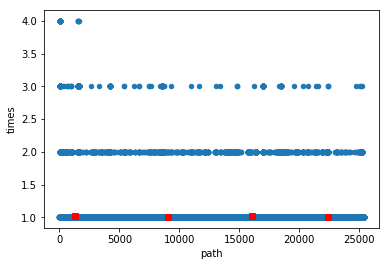

In [20]:
from pyspark.sql import Row
import pandas as pd
import matplotlib.pyplot as plt

pdf = (rdd_final.map(lambda (path,times) : Row(path=path,times=times))).toDF()
pdf = pdf.toPandas()
centers = pd.DataFrame({'x': centerX , 'y': centerY})
pdf.plot(kind='scatter',x ='path',y='times')
plt.plot(centerX,centerY,'rs')
plt.show()